In [40]:
# %matplotlib inline
# %matplotlib notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as mpl3d
from matplotlib import cm
from scipy import signal
from scipy import stats
from scipy import linalg
from scipy import fft
from scipy import io

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(123)

In [68]:
class Util:
    def __init(self):
        pass

    @classmethod
    def round_power2(self, x):
        assert x > 0.
        assert not np.iscomplex(x)
        return int(np.power(2., np.ceil(np.log2(x))))

    @classmethod
    def sample_time(self, f_sample, n):
        assert n > 0, 'n must be greater than 0'
        assert f_sample > 0.
        return n / f_sample

    @classmethod
    def dB_power(self, x):
        assert x > 0
        assert not np.iscomplex(x)
        return 10. * np.log10(x)

    @classmethod
    def dB(self, x):
        assert x > 0
        assert not np.iscomplex(x)
        return 20. * np.log10(x)

    @classmethod
    def signal_power(self, x, dB=True):
        assert x.ndim == 1
        p = np.sum(np.abs(x)**2.) / len(x)
        if dB:
            return self.dB_power(p)
        else:
            return p
        
    @classmethod
    def snr(self, x, y, dB=True):
        assert x.ndim == 1
        assert y.ndim == 1
        snr = self.signal_power(x, dB=False) / self.signal_power(y, dB=False)
        if dB:
            return self.dB_power(snr)
        else:
            return snr


class WirelessMicrophone:
    def __init__(self, f_sample=1000.0, n=None, t_sec=None):
        assert f_sample > 0, 'must be greater than 0'
        if n is not None:
            assert n > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.n = int(n)
            self.t_sec = self.n / self.f_sample
        elif t_sec is not None:
            assert t_sec > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.t_sec = t_sec
            self.n = int(self.t_sec* self.f_sample)
        else:
            assert False, 'either n or t_sec needed'

    def get_signal(self, f_center, f_deviation, f_modulation, dB=0.):
        t = np.arange(self.n) / self.f_sample
        x = np.exp(1.j *
                   (2. * np.pi * f_center * t + f_deviation / f_modulation *
                    np.sin(2. * np.pi * f_modulation * t)))
        x -= np.mean(x) # normalize signal
        x /= np.std(x)  # ^  
        x *= 10.**(dB / 20.)
        return x

    def get_silent(self, f_center, dB=0.):
        return self.get_signal(f_center, 5000, 32000, dB)

    def get_soft(self, f_center, dB=0.):
        return self.get_signal(f_center, 3900, 15000, dB)

    def get_loud(self, f_center, dB=0.):
        return self.get_signal(f_center, 13400, 32600, dB)


class WhiteGaussianNoise:
    def __init__(self, f_sample=1000.0, n=None, t_sec=None):
        assert f_sample > 0, 'must be greater than 0'
        if n is not None:
            assert n > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.n = int(n)
            self.t_sec = self.n / self.f_sample
        elif t_sec is not None:
            assert t_sec > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.t_sec = t_sec
            self.n = int(self.t_sec* self.f_sample)
        else:
            assert False, 'either n or t_sec needed'

    def get_signal(self, dB=0.):
        x = 10.**(dB / 10.)
        x = stats.multivariate_normal(mean=[0., 0.],
                                      cov=[[.5 * x, 0.], [0., .5 * x]])
        x = x.rvs(size=self.n).view(np.complex128).reshape(self.n)
        return x
    
sample_frequency = 1e6 # in Hz
length           = 1.0 # in s
signal_strength  = 0.0 # in dB
noise_strength   = 0.0 # in dB
    
wm = WirelessMicrophone(f_sample=sample_frequency, t_sec=length)
# wm = WirelessMicrophone(f_sample=sample_frequency, n=1e5)
sig = wm.get_signal(f_center=1e5, f_deviation=15000, f_modulation=3900, dB=signal_strength)

wgn = WhiteGaussianNoise(f_sample=sample_frequency, t_sec=length)
noise = wgn.get_signal(dB=noise_strength)

both = sig + noise

print(f'wm.f_sample {wm.f_sample}')
print(f'wm.n        {wm.n}')
print(f'wm.t_sec    {wm.t_sec}')

sample_freq = wm.f_sample

print('Signal power: %4.2f dB' % (Util.signal_power(sig, dB=True)))
print('Noise power: %5.2f dB' % (Util.signal_power(noise, dB=True)))
print('SNR: %13.2f dB' % (Util.snr(sig, noise, dB=True)))

wm.f_sample 1000000.0
wm.n        1000000
wm.t_sec    1.0
Signal power: 0.00 dB
Noise power: -0.00 dB
SNR:          0.00 dB


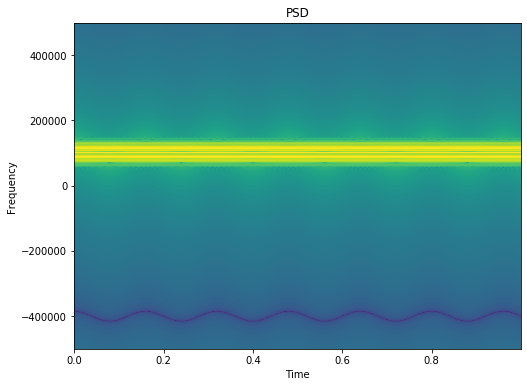

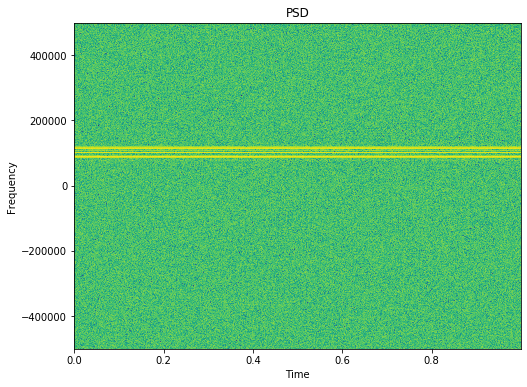

In [69]:
# Matplotlib Spectogram

# plt.figure(figsize=(8, 6))
# plt.specgram(noise,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(sig,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(both,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [71]:
class TimeED():
    def __init__(self):
        pass
    
    @classmethod
    def get(self, x):
        return np.sum(np.abs(x) ** 2.)

en_sig = TimeED.get(sig)
print(f'Energy signal {en_sig}')
en_both = TimeED.get(both)
print(f'Energy both   {en_both}')

Energy signal 1000000.0
Energy both   1999483.6466867798


In [ ]:
def get_fft_psd(sig, fs, N):
    assert N == len(sig) 
    f_tmp = fft.fftfreq(N, 1. / fs)
    f = fft.fftshift(f_tmp)
    x_tmp = fft.fft(sig)
    x = fft.fftshift(x_tmp)
    x = np.abs(x)**2. / (N * fs)
    return f, x


def get_energy_from_psd(psd):
    return np.sum(psd)


def get_power_from_psd(psd, f):
    df = f[1] - f[0]
    return np.sum(psd) * df

In [ ]:
power_sig_time = signal_power(sig)
energy_sig_time_from_power_sig_time = power_sig_time * N * 1. / fs  # where 1./fs=dt and T=(N*1./fs)
print('Signal power in time %8.6f' % (power_sig_time))
print('Signal energy in time from signal power in time %8.6f' %
      (energy_sig_time_from_power_sig_time))

plt.figure(figsize=(8, 6))
f, psd = get_fft_psd(sig, fs, N)
plt.semilogy(f, psd)
plt.show()
plt.figure(figsize=(8, 6))
# psd_log = 10. * np.log10(psd)
# psd_log = psd
# plt.plot(f, psd_log)
plt.show()

print('Signal power from psd %8.6f' % (get_power_from_psd(psd, f)))
print('Signal energy from psd %8.6f' % (get_energy_from_psd(psd)))

get_power_from_psd(psd, f) * 0.13107

In [ ]:
# window_size = 1024

# sig1 = sig[0:1024]
# plt.figure(figsize=(8, 6))
# f_welch, psd_welch = signal.welch(sig1,
#                                   fs,
#                                   window='flattop',
#                                   nperseg=window_size,
#                                   noverlap=0,
#                                   nfft=window_size,
#                                   detrend=False,
#                                   scaling='density',
#                                   return_onesided=False)
# f_welch = fft.fftshift(f_welch)
# psd_welch = fft.fftshift(psd_welch)
# plt.figure(figsize=(8, 6))
# # plt.semilogy(f_welch, psd_welch)
# plt.plot(f_welch, psd_welch)
# plt.show()

# df_welch = f_welch[1] - f_welch[0]
# welch_power = np.sum(psd_welch) * df_welch
# print('Signal power from welch %8.6f' % (welch_power))

# welch_energy = welch_power * 1./fs * window_size
# print('Signal energy from welch %8.6f' % (welch_energy))

In [ ]:

class Stft:
    
    def __init__(self, n=1024, window='flattop'):
        assert self.is_power2(n)
        self.n = n
        self.window = signal.get_window(window, self.n)
        
    def is_power2(self, n):
        '''Check least significant bit for power of two.'''
        return (n != 0) and (n & (n-1) == 0)
    
    def fft(self, sig, fs):
        '''Compute FFT and spectrum shifted to natural order.'''
        dt = 1./fs
        f = fft.fftshift(fft.fftfreq(len(sig), dt))
        s = fft.fftshift(fft.fft(sig))
        return f, s

    def apply_window(self, sig):
        return sig * self.window
    
    def stft_helper(self, sig, fs):
        return self.fft(self.apply_window(sig), fs)
    
    def stft(self, sig, fs):
        segs = [sig[i:i + self.n] for i in range(0, len(sig), self.n)]
        for i in segs:
            f, x = self.stft_helper(i, fs)
            yield f, x
            
    def apply_psd(self, sig, fs):
#         return np.abs(sig)**2. / (len(sig) * fs)
        return np.abs(sig)**2. / (fs * (self.window**2).sum())

    def dB(self, psd):
        return 10. * np.log10(psd)

    def psd(self, sig, fs):
        for f, x in self.stft(sig, fs):
            yield f, self.apply_psd(x, fs)
        
    def spectogram(self, sig, fs, dB=True):
        tl = list()
        xl = list()
        i = 0
        for f, x in self.psd(sig, fs):
            tl.append(i*self.n*1./fs)
            i += 1
            if dB:
                xl.append(self.dB(x))
            else:
                xl.append(x)
        xl = np.swapaxes(xl, 0, 1)
        return f, tl, xl


sft = Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, fs, False)

plt.figure(figsize=(8, 6))
plt.semilogy(f, x[:, 2])
# plt.plot(f, x[:, 2])
# plt.plot(150000, 10e-14, 'x')
plt.show()

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(t,
#                f,
#                x,
#                shading='flat',
#                cmap='viridis',
#                snap=True,
#                vmin=np.min(x),
#                vmax=np.max(x))
# plt.title('STFT Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

In [ ]:
class ED:
        
    def __init__(self, num_bands, fs, fft_len, f):
        self.num_bands = num_bands
        self.fft_len = fft_len
        self.di = fft_len / num_bands
        self.df = f[1] - f[0]
        self.fs = fs
        self.f = f
        assert self.df == (self.fs/self.fft_len)
        
    def energy(self, ps):
        return np.sum(np.abs(ps) ** 2)/self.fs
    
    def segs(self, ps):
        f_segs = list()
        ps_segs = list()
        for i in range(int(self.num_bands)):
            idx1 = int(i*self.di)
            idx2 = int((i+1)*self.di)
            f_segs.append(self.f[idx1:idx2])
            ps_segs.append(ps[idx1:idx2])
        return f_segs, ps_segs
    
    def detect(self, ps):
        f_segs, ps_segs = self.segs(ps)
        en_segs = list()
        for i in range(int(self.num_bands)):
            plt.figure(figsize=(8, 6))
            plt.semilogy(f_segs[i], ps_segs[i])
            plt.show()
            en_segs.append(self.energy(ps_segs[i]))
        return en_segs
    
    
ed = ED(num_bands=8, fs=fs, fft_len=1024, f=f)
en = ed.detect(x[:, 2])

plt.figure(figsize=(8, 6))
plt.plot(en)
plt.show()

In [ ]:
import scipy.ndimage

def clip_2d(x, lim_min, lim_max):
    (x, y) = np.shape(Sxx)
    for i in range(x):
        for j in range(y):
            Sxx[i, j] = max(min(Sxx[i, j], lim_max), lim_min)
    return Sxx

def smooth_2d(x, sigma):
    return scipy.ndimage.filters.gaussian_filter(x, [sigma, sigma], mode='mirror')

def crop_2d(Sxx, f, t, n):
    Sxx = Sxx[n:-n, n:-n]
    f = f[n:-n]
    t = t[n:-n]
    return Sxx, f, t

In [ ]:
f, t, Sxx = signal.spectrogram(both, fs, return_onesided=False, window='hann', nperseg=1024, nfft=1024, noverlap=0, detrend=False, scaling='density', mode='psd')

f = fft.fftshift(f)
Sxx = fft.fftshift(Sxx, axes=0)

Sxx = 10.0*np.log10(Sxx)
Sxx = clip_2d(Sxx, -60, 0)
Sxx = smooth_2d(Sxx, 2)
# Sxx, f, t = crop_2d(Sxx, f, t, 4)

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
# ax.get_proj = lambda: np.dot(mpl3d.axes3d.Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))
ax.plot_surface(f[:, None], t[None, :], Sxx, cmap='viridis', rstride=1, cstride=1, alpha=1, antialiased=True)
ax.view_init(elev=30, azim=70)
plt.show()
plt.savefig('test.png')  